In [272]:
import numpy as np
import sympy
from sympy import symbols, Eq, linear_eq_to_matrix
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
# from pyeda.inter import expr, exprvar, expr2bdd
from dd.autoref import BDD
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
import pandas as pd
from sympy.logic.boolalg import SOPform
import re
import pickle

In [190]:
class PATH:
    def __init__(self, CrossbarGridSize = 16):
        self.CrossbarGridSize = CrossbarGridSize
        self.Crossbar_sizes = [2**i for i in range(3,16)]

        self.pre_bool_expressions = None
        self.pre_varibles_lst = None
        self.nodeID_map = None

        self.filename = None
        self.model_name = None
        self.inputs = []
        self.outputs = []

        self.OriginalTruthTable = None
        self.TruthTable = None
        
        self.BDD = None
        self.Graph = None
        self.Expressions = None
        self.NodeIDMap = None
        self.InputNode = None
        self.GraphProcessPhase = None
        self.CrossbarResistiveStates = None
        self.Bitlines = None

        self.TreeMapInNodes = {}
        self.xlabelsOfLiterals_map = {}
        self.OutputLine_Map = {}

    def parse_file_to_NetworkXGraph(self, filename):
        """ Reads the file and extracts nodes, variables, and outputs. """
        self.filename = filename
        with open(self.filename, 'r') as file:
            lines = [line.strip() for line in file if line.strip()]

        unprocessed_lines = []
        for line in lines:
            if line.startswith('.model'):
                self.model_name = line.split()[1:]
            elif line.startswith('.outputs'):
                self.outputs = line.replace(".outputs", "").replace(";", "").strip().split()
            elif line.startswith('.bdd') or line.startswith('.order') or line.startswith('.inputs') or line.startswith('.outputs'):
                continue  # Ignore section marker
            elif line.startswith('.end'):
                break  # Stop parsing at .end
            else:
                unprocessed_lines.append(line)
        self._parse_bdd_lines(unprocessed_lines)

    def _parse_bdd_lines(self, lines):
        """ Parses a BDD node definition line and assigns node colors. """
        outputLiteral = {}
        self.NodeIDMap = {}
        self.Expressions = {}
        self.TreeMapInNodes = {}
        
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) == 5:
                node_id, high_child_id, low_child_id, var, output = parts  # Root node
            elif len(parts) == 4:
                node_id, high_child_id, low_child_id, var = parts
                output = None  # Some nodes may not specify an explicit output
            else:
                return  # Skip malformed lines
    
            # Convert to integers where applicable
            node_id = int(node_id, 16) if re.match(r'^[0-9a-fA-F]+$', node_id) else int(node_id)
            low_child_id = int(low_child_id, 16) if low_child_id != "-1" else -1
            high_child_id = int(high_child_id, 16) if high_child_id != "-1" else -1
            
            if(var=='0'):
                outputLiteral[node_id] = var
            elif(var=='1'):
                outputLiteral[node_id] = var
            else:
                # Store node structure in TreeMapInNodes
                self.TreeMapInNodes[str(node_id)] = {
                    "variable": var,
                    "low": low_child_id,
                    "high": high_child_id,
                    "negation": False,  # Assuming no negation flag in file
                }
    
            # Store reference count in NodeIDMap
            if node_id not in self.NodeIDMap:
                self.NodeIDMap[str(node_id)] = [0, var]
            self.NodeIDMap[str(node_id)][0] += 1
    
            # Track root nodes per output variable
            if output:
                self.Expressions[output] = str(node_id)

    def TruthTable_to_BooleanExpression(self, df, outputs):

        # Need to validate
        self.OriginalTruthTable = df
        self.outputs = outputs

        def get_minterm_index(row):
            minterm_str = ""
            for col in df.columns:
                # if("F" not in col):
                if(col not in outputs):
                    minterm_str = minterm_str + row[col]
            return int(minterm_str, 2)

        expressions = {}
        # variables = [symbols(col) for col in df.columns if 'F' not in col]
        variables = [symbols(col) for col in df.columns if col not in outputs]
        varibles_str_lst = []

        for col in df.columns:
            # if('F' in col):
            if(col in outputs):
                minterms_col = [get_minterm_index(row) for idx, row in df.iterrows() if row[col] == '1']
                expressions[col] = str(SOPform(variables, minterms_col))
            else:
                varibles_str_lst.append(col)

        self.pre_varibles_lst = varibles_str_lst
        self.pre_bool_expressions = expressions

        for expression in expressions:
            print(expression,':',expressions[expression])

    def SetBooleanExpressionsAndVaribles(self, variables=None, expressions=None, outputs=None, OriginalTruthTable=None):
        if(variables!=None):
            self.pre_varibles_lst = variables
        if(expressions!=None):
            self.pre_bool_expressions = expressions
        if(outputs!=None):
            self.outputs = outputs
        if OriginalTruthTable is not None:
            self.OriginalTruthTable = OriginalTruthTable
        
    def BooleanExpresions_to_BDD(self):
        variables = self.pre_varibles_lst    
        expressions = self.pre_bool_expressions
        
        # Initialize the BDD manager
        self.BDD = BDD()
        # self.BDD.configure(reordering=True)
        
        # Declare variables
        self.BDD.declare(*variables)
        # self.BDD.declare('a', 'b', 'c', 'd')
        # self.BDD.declare('a0', 'b0', 'cin',)
        
        # Define Boolean expressions
        self.expressions = expressions
        # self.expressions = {
        #     'P0': 'a & b',
        #     'P1': '(a & b) ^ (c & d)',
        #     'P2': '(a & c) ^ ((a & b) & (c & d))',
        #     'P3': '(a & c) & ((a & b) & (c & d))'
        # }
        
        # self.expressions = {'c_out': '(a0 & b0) | (a0 & cin) | (b0 & cin)', 's_0': 'a0 ^ b0 ^ cin'}
        self.Expressions = {expression: self.BDD.add_expr(self.expressions[expression]) for expression in self.expressions}
        
        self.BDD.collect_garbage()
        # self.BDD.reorder()

        self.TreeMapInNodes = {}
        self.NodeIDMap = {}
        for rootKey in self.Expressions:
            # queue = [(self.Expressions[rootKey], self.Expressions[rootKey].negated)]
            queue = [(self.Expressions[rootKey], False)]
            while(queue):
                curr_ele, neg = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)

                # Store current node structure in TreeMapInNodes
                lowValue = None
                highValue = None

                neg1 = not neg if curr_ele.negated else neg

                neg2 = not neg if curr_ele.negated else neg
                
                if node1.var:
                    lowValue = str(node1)
                else:
                    lowValue = str(node1)
                    # lowValue =  node1.negated if neg1 else not node1.negated
                    
                if node2.var:
                    highValue = str(node2)
                else:
                    highValue = str(node2)
                    # highValue = node2.negated if neg2 else not node2.negated

                self.TreeMapInNodes[str(curr_ele)] = {
                    "variable": curr_ele.var,
                    "negation": curr_ele.negated,
                    "low": lowValue,
                    "high": highValue
                }
                
                if(str(curr_ele) not in self.NodeIDMap):
                    self.NodeIDMap[str(curr_ele)]=[0, curr_ele.var]
                self.NodeIDMap[str(curr_ele)][0]+=1
                
                if node1.var!=None:
                    queue.append((node1, neg1))
                else:
                    if(str(node1) not in self.NodeIDMap):
                        self.NodeIDMap[str(node1)]=[0, '0' if node1.negated else '1']
                    self.NodeIDMap[str(node1)][0]+=1
                
                if node2.var!=None:
                    queue.append((node2, neg2))
                else:
                    if(str(node2) not in self.NodeIDMap):
                        self.NodeIDMap[str(node2)]=[0, '0' if node2.negated else '1']
                    self.NodeIDMap[str(node2)][0]+=1

    def BDD_to_NetworkXGraph(self):
        # Initialize an undirected graph
        self.Graph = nx.DiGraph()
        ExpressionsRev = {str(self.Expressions[key]):key for key in self.Expressions}

        # print('---------------------------------')
        # #debug code by nithin
        # print('self.NodeIDMap', self.NodeIDMap)
        # print()
        # print('ExpressionsRev', ExpressionsRev)
        # print()
        # print('self.TreeMapInNodes', self.TreeMapInNodes)
        # print('---------------------------------')
        #adding nodes
        for id_str in self.NodeIDMap:
            literal = self.NodeIDMap[id_str][1]
            ExpressionRoot = None
            if(id_str in ExpressionsRev):
                ExpressionRoot = ExpressionsRev[id_str]
                literal = literal + '('+str(ExpressionsRev[id_str])+')'
                
            attributes = {'ID': id_str, 'literal': literal, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}

            # Add nodes with attributes to the graph
            self.Graph.add_node(id_str, **attributes)

        for rootKey in self.TreeMapInNodes:
            node1 = self.TreeMapInNodes[rootKey]['low']
            node2 = self.TreeMapInNodes[rootKey]['high']
                
            self.Graph.add_edge(str(rootKey), str(node1), label='0')
            self.Graph.add_edge(str(rootKey), str(node2), label='1')

        self.GraphProcessPhase = "0. BDD creation"

    def Verify_BDD_to_NetworkXGraph(self, withExpression=False, withOriginalTruthTable=False):
        """
        Verifies if the BDD truth table representation matches the expected truth table.
        """

        outputs = self.outputs
        dfs = []
        prompt_msg = []
        if(withOriginalTruthTable):
            if(self.OriginalTruthTable is not None):
                prompt_msg.append('Verifying BDD against the original truth table...')
                dfs.append(self.OriginalTruthTable)
                # print('self.OriginalTruthTable.columns',self.OriginalTruthTable.columns)
            else:
                print("No Original Truth table(user given truth table) exists")

        if(withExpression):
            if(self.pre_bool_expressions and self.pre_varibles_lst):
                prompt_msg.append('Verifying BDD against the expressions evaluated truth table...')
                self.GetTruthTables()
                dfs.append(self.TruthTable)
            else:
                print("No  Evaluated Truth table exists")

        flag = True
        
        for i, df in enumerate(dfs):
            # Extract input and output column names from the dataframe
            input_columns = [col for col in df.columns if col not in outputs]  # Variables
            output_columns = [col for col in df.columns if col in outputs]  # Expressions (functions)

            # Iterate over each row in the dataframe (each row represents an input assignment)
            for idx, row in df.iterrows():
                input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
                expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

                
                computed_outputs = {}  # Store computed values from BDD traversal

                # Evaluate each expression using the BDD
                for expr in output_columns:
                    if expr not in self.Expressions:
                        print(f"Error: Expression {expr} not found in BDD.")
                        continue
                    
                    current_node = str(self.Expressions[expr])  # Start traversal from the root node of the expression
                    
                    while True:
                        # Get node attributes
                        if current_node not in self.Graph.nodes:
                            print(f"Error: Node {current_node} not found in graph.")
                            return None
                
                        node_data = self.Graph.nodes[current_node]
                        # print(f"Visiting Node {current_node}: {node_data}")

                        # If it's a terminal node, return the computed output (0 or 1)
                        if node_data["literal"] in {"0", "1"}:
                            computed_outputs[expr] = int(node_data["literal"])
                            break
                        
                        # Extract the literal (decision variable)
                        literal = node_data["literal"].split('(')[0]  # Extracts 'a' from 'a(y)'

                        # Determine next node based on input assignment
                        if literal in input_assignment:
                            next_node = None
                            if input_assignment[literal] == 0:
                                next_node = list(self.Graph.successors(current_node))[0]  # Low branch
                            else:
                                next_node = list(self.Graph.successors(current_node))[1]  # High branch
                            
                            current_node = next_node  # Move to the next node
                        else:
                            print(f"Error: Variable '{literal}' not in input assignment.")
                            return None

                # print('input_assignment', input_assignment)
                # print('expected_outputs', expected_outputs)
                # Compare computed outputs with expected outputs
                for expr in output_columns:
                    if computed_outputs.get(expr) != expected_outputs[expr]:
                        print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                              f"Expected {expected_outputs}, Got {computed_outputs}")
                        flag=False

            if(flag):
                print("BDD has no issues")
            print("BDD verification completed.")
            
    def GraphPreprocessing(self):
        #Re-label the edges
        for u, v, data in self.Graph.edges(data=True):
            # Retrieve the parent node's literal
            parent_literal = self.Graph.nodes[u].get('literal').split('(')[0]
            
            # Ensure the parent_literal is valid (not None) and the edge has a label
            if parent_literal and 'label' in data:
                # Update the edge label based on the parent node's literal
                if data['label'] == '0':
                    # For '0', add a negation (~) to the parent's literal
                    data['label'] = f"~{parent_literal}"
                elif data['label'] == '1':
                    # For '1', use the parent's literal directly
                    data['label'] = parent_literal

        # Remove the node with literal='0' and id='@-1' along with its connections
        nodes_to_remove = [node for node, data in self.Graph.nodes(data=True) if data.get('literal') == '0']
        for node in nodes_to_remove:
            self.Graph.remove_node(node)


        #Invert all edges in the graph 
        inverted_graph = nx.DiGraph()
        inverted_graph.add_nodes_from(self.Graph.nodes(data=True))
        inverted_graph.add_edges_from([(v, u, data) for u, v, data in self.Graph.edges(data=True)])
        self.Graph = inverted_graph

        # Store the root node (in RootNode) after inversion        
        self.InputNode = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('literal')=='1' and self.Graph.in_degree(node) == 0][0]

        #Re-label the nodes
        Counter = 1
        queue = [self.InputNode]
        visited = set()
        while queue:
            current_node = queue.pop(0)

            if current_node in visited:
                continue
            visited.add(current_node)

            # Update node labels for the current node's
            self.Graph.nodes[str(current_node)]['literal'] = str(Counter)
            Counter+=1

            for _, target_node, edge_data in self.Graph.out_edges(str(current_node), data=True):
                queue.append(target_node)
                
        self.GraphProcessPhase = "1. Graph pre-processed"

    def GraphTransformation(self):
        # First mark all the old nodes with attribute as BipartitePart='U1'
        for node in self.Graph.nodes:
            self.Graph.nodes[node]['BipartitePart'] = 'U1'
    
        # Initialize a list to store new edges transformed into nodes
        new_nodes = []
        edge_counter = 1  # Counter for unique IDs for new nodes
    
        # Iterate through all edges in the graph
        for u, v, data in list(self.Graph.edges(data=True)):
            # Create a new node for the edge
            new_node_id = f"EdgeNode_{edge_counter}"
            edge_label = data.get('label', 'NoLabel')
            new_node_attributes = {
                'ID': new_node_id,
                'literal': edge_label,
                'BipartitePart': 'U2'
            }
    
            # Add the new node to the graph
            self.Graph.add_node(new_node_id, **new_node_attributes)
    
            # Connect the new node to the original source and target nodes
            self.Graph.add_edge(u, new_node_id, label='')
            self.Graph.add_edge(new_node_id, v, label='')
    
            # Remove the original edge
            self.Graph.remove_edge(u, v)
    
            # Keep track of the newly created node
            new_nodes.append(new_node_id)
    
            edge_counter += 1
    
        # Update the graph process phase
        self.GraphProcessPhase = "2. Graph Transformation"


    def GraphCompression(self):
        # Create a dictionary to store U2 node literals as keys and input node literals as values in a list
        compression_dict = {}

        # Iterate through all U2 nodes
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('BipartitePart') == 'U2':
                # Get the literal of the current U2 node
                u2_literal = self.Graph.nodes[node].get('literal')
                u2_id = self.Graph.nodes[node].get('ID')

                # Collect input node literals (U1) connected to this U2 node
                if(u2_literal not in compression_dict):
                    compression_dict[u2_literal] = {}

                if(u2_id not in compression_dict[u2_literal]):
                    compression_dict[u2_literal][u2_id] = []
                
                for predecessor in self.Graph.predecessors(node):
                    if self.Graph.nodes[predecessor].get('BipartitePart') == 'U1':
                        compression_dict[u2_literal][u2_id].append(self.Graph.nodes[predecessor].get('literal'))

        # Merge U2 nodes with the same literal if they have the same input edges
        for u2_literal, nodes in compression_dict.items():
            merged_inputs = {}
            for node_id, inputs in nodes.items():
                inputs_tuple = tuple(sorted(inputs))  # Sort to handle duplicate edge inputs
                if inputs_tuple not in merged_inputs:
                    merged_inputs[inputs_tuple] = node_id
                else:
                    # Merge this node into the existing one
                    existing_node_id = merged_inputs[inputs_tuple]

                    # Redirect all outgoing edges from the current node to the existing node
                    for _, successor, edge_data in list(self.Graph.out_edges(node_id, data=True)):
                        self.Graph.add_edge(existing_node_id, successor, **edge_data)

                    # Remove the current node
                    self.Graph.remove_node(node_id)


        # Track the next available EdgeNode index
        edge_node_index = max(
            [int(node.split("_")[-1]) for node in self.Graph.nodes if "EdgeNode_" in str(node)],
            default=13  # Assuming EdgeNode_13 is the last used
        ) + 1
        
        self.OutputLine_Map = {}
        for node in list(self.Graph.nodes):
            node_data = self.Graph.nodes[node]
            # print('node_data',node_data)
            if node_data.get("ExpressionRoot") is not None:  # If ExpressionRoot is not None
                new_edge_node_id = f"EdgeNode_{edge_node_index}"  # Create a new EdgeNode
        
                # Add the new node with '1' as the literal and 'U2' as BipartitePart
                self.Graph.add_node(new_edge_node_id, ID=new_edge_node_id, literal="O"+str(edge_node_index), BipartitePart="U2")
                
                # Connect the original node to the new EdgeNode
                self.Graph.add_edge(node, new_edge_node_id)
                
                self.OutputLine_Map["O"+str(edge_node_index)] = self.Graph.nodes[node].get('ExpressionRoot')

                edge_node_index += 1  # Increment for the next node

        # print('self.OutputLine_Map',self.OutputLine_Map)

        # Update the graph process phase
        self.GraphProcessPhase = "3. Graph Compression"

    def CrossbarRelalization(self):

        self.colMap, counter = {}, 0
        for node in self.Graph.nodes:
            if(self.Graph.nodes[node]['BipartitePart']=='U2'):
                self.colMap[self.Graph.nodes[node]['ID']] = counter
                counter += 1

        #start of setting the crossbar size
        max_CrossbarGridSize = 0
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]
            max_CrossbarGridSize = max(max_CrossbarGridSize, row_i, col_j)
            
        for i,Crossbar_size in enumerate(self.Crossbar_sizes):
            if(Crossbar_size>=max_CrossbarGridSize):
                self.CrossbarGridSize = Crossbar_size
                break
        print("Suitable Crossbar size:", self.CrossbarGridSize)
        
        self.CrossbarResistiveStates = [[0 for _ in range(self.CrossbarGridSize)] for _ in range(self.CrossbarGridSize)]
        #end of setting crossbar size        

        
        self.Bitlines = []
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
                
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]

            self.Bitlines = [f"C{i+1}" for i in range(self.CrossbarGridSize)]
            for col in self.colMap:
                self.Bitlines[self.colMap[col]] = self.Graph.nodes[col]['literal']
            
            self.CrossbarResistiveStates[row_i][col_j] = 1
            
            
        self.GraphProcessPhase = "4. Crossbar Realization"
    
    def DisplayEdgesInNetworkXGraph(self):
        # Iterate through all edges in the graph
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            # Retrieve the edge label; default to 'No label' if not present
            edge_label = data.get('label', 'No label')
            print(f"{next(iter(self.NodeIDMap[u][1]))[0]}({u}) -[{edge_label}]-> {next(iter(self.NodeIDMap[v][1]))[0]}({v})")

    def VisuvaliseNetworkXGraph(self, bipartite=False):
        # Initialize position dictionary
        pos = {}
        
        # Parameters for positioning
        HORIZONTAL_SPACING = 1.0  # Horizontal distance between nodes
        VERTICAL_SPACING = 3.0    # Vertical distance between layers
        
        # Separate nodes into categories
        root_nodes = [node for node in self.Graph.nodes if self.Graph.in_degree(node) == 0]
        leaf_nodes = [node for node in self.Graph.nodes if self.Graph.out_degree(node) == 0]
        intermediate_nodes = [node for node in self.Graph.nodes if node not in root_nodes + leaf_nodes]

        if(bipartite):
            # Separate nodes by BipartitePart
            u1_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U1']
            u2_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U2']
    
            # Assign positions to U1 nodes (left column)
            for i, node in enumerate(u1_nodes):
                pos[node] = (0, (i * VERTICAL_SPACING))

            # Assign positions to U2 nodes (right column)
            for i, node in enumerate(u2_nodes):
                pos[node] = (2, (i * VERTICAL_SPACING))
                    
        else:
            # Assign positions to ExpressionRoot nodes (top layer)
            for i, node in enumerate(root_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, 0)
                # print((i * HORIZONTAL_SPACING, 0))
            
            # Assign positions to Intermediate nodes based on BFS layers
            # Start BFS from all ExpressionRoot nodes
            layers = list(nx.bfs_layers(self.Graph, root_nodes))
            
            for lvl, nodes in enumerate(layers):
                # print("Layer:")
                for i, node in enumerate(nodes):
                    if node in intermediate_nodes:  # Only position intermediate nodes
                        # print(next(iter(idSet[node][1]))[0], end=",")
                        pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl))
                        # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl)))
                # print("\n")
    
            leafnodeYaxis = len(layers)
            if(self.Graph.nodes[layers[0][0]].get('literal')=="1"):
                leafnodeYaxis = leafnodeYaxis - 1
            
            # print("Literals")
            # Assign positions to Literal nodes (bottom layer)
            for i, node in enumerate(leaf_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis))
                # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis)))
        
        # Draw nodes with labels
        node_colors = []
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                node_colors.append('orange')
            elif self.Graph.nodes[node].get('literal') == '0':
                node_colors.append('red')
            elif self.Graph.nodes[node].get('literal') == '1':
                node_colors.append('green')
            else:
                node_colors.append('lightblue')  # Default color for intermediate nodes

        nx.draw(self.Graph, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=10, arrows=True, arrowstyle='->', arrowsize=20)
        
        # Draw literals as node labels
        node_labels = nx.get_node_attributes(self.Graph, 'literal')
        nx.draw_networkx_labels(self.Graph, pos, labels=node_labels, font_size=12, font_color='black')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.Graph, 'label')
        nx.draw_networkx_edge_labels(self.Graph, pos, edge_labels=edge_labels, font_color='red')
        
        # Display the graph
        plt.title(self.GraphProcessPhase if self.GraphProcessPhase is not None else "Graph with Node Attributes and Edge Labels")
        plt.show()

    def VisuvaliseCrossbar(self):
        crossbar_matrix = np.array(self.CrossbarResistiveStates)
        
        colors = ["red", "blue"]
        custom_cmap = ListedColormap(colors)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap = ax.imshow(crossbar_matrix, cmap=custom_cmap, aspect="auto")

        # Annotate the heatmap with 'LRS' or 'HRS'
        for i in range(crossbar_matrix.shape[0]):
            for j in range(crossbar_matrix.shape[1]):
                text = "LRS" if crossbar_matrix[i, j] == 1 else "HRS"
                ax.text(j, i, text, ha="center", va="center", 
                        color="white" if crossbar_matrix[i, j] == 1 else "black", 
                        fontsize=10, weight="bold")

        # Add gridlines for cell borders
        ax.set_xticks(np.arange(crossbar_matrix.shape[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(crossbar_matrix.shape[0] + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.tick_params(which="minor", size=0)

        # Set labels and title
        ax.set_xlabel("Columns", fontsize=12, weight="bold")
        ax.set_ylabel("Rows", fontsize=12, weight="bold")
        ax.set_title("Crossbar Resistive States", fontsize=14, weight="bold")

        xlabelsOfLiterals = [f"C{i+1}" for i in range(crossbar_matrix.shape[0])]
        for col in self.colMap:
            xlabelsOfLiterals[self.colMap[col]] = self.Graph.nodes[col]['literal']

        #shif this to functional functions
        # xlabelsOfLiterals ['a1', 'a0', '~a1', '~a1', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
        self.xlabelsOfLiterals_map = {}
        for i,xlabelsOfLiteral in enumerate(xlabelsOfLiterals):
            
            only_label = xlabelsOfLiteral if xlabelsOfLiteral[0]!='~' else xlabelsOfLiteral[1:]
            negation = False if xlabelsOfLiteral[0]!='~' else True
            
            if(only_label not in self.xlabelsOfLiterals_map):
                self.xlabelsOfLiterals_map[only_label] = []
            self.xlabelsOfLiterals_map[only_label].append((i, negation))

        # Remove default ticks
        ax.set_xticks(np.arange(crossbar_matrix.shape[1]))
        ax.set_yticks(np.arange(crossbar_matrix.shape[0]))
        ax.set_xticklabels(xlabelsOfLiterals, fontsize=10)
        ax.set_yticklabels([f"{j+1}" for j in range(crossbar_matrix.shape[1])], fontsize=10)

        # Show the heatmap
        plt.colorbar(heatmap, label="Resistive State", orientation="vertical")
        plt.tight_layout()
        plt.show()

    def IdealCurrentPath(self, literal_value_map):
        
        # literal_value_map = {'a':0, 'b':0, 'cin':1}
        # print('literal_value_map',literal_value_map)
        
        #bitline labels according to crossbar #niti
        # self.Bitlines = ['a', '~a', '~a', 'a', 'b', '~b', '~b', 'b', 'b', '~cin', 'cin', 'O14', 'O15']
        bitlines = self.Bitlines

        R_LRS = 1
        R_HRS = 0
        Resistance_matrix = [row.copy() for row in self.CrossbarResistiveStates]
        # Resistance_matrix = self.CrossbarResistiveStates.copy()

        SelectorLines = [0 for _ in range(len(Resistance_matrix[0]))]
        for i,bitline in enumerate(bitlines):
            literal = bitline
            negation = literal.startswith('~')
            if(negation):
                literal = literal[1:]

            if('O' in literal):
                SelectorLines[i] = 1
            elif(literal in literal_value_map and literal_value_map[literal]==0):
                if(negation):
                    SelectorLines[i] = 1
                else:
                    SelectorLines[i] = 0
            elif(literal in literal_value_map and literal_value_map[literal]==1):
                if(negation):
                    SelectorLines[i] = 0
                else:
                    SelectorLines[i] = 1

        # print('SelectorLines',SelectorLines)
        #Swiching off the bitlines
        for col, SelectorLine in enumerate(SelectorLines):
            if(SelectorLine==0):
                for row in range(len(Resistance_matrix)):
                    Resistance_matrix[row][col] = R_HRS
            

        #finding output paths
        OutputPaths = {}
        OutputPaths_labelTocell = {}
        # self.OutputLine_Map = {'O14': 'cout', 'O15': 'sum'}
        for col,bitline in enumerate(bitlines):
            literal = bitline
            if('O' in literal):
                for row in range(len(Resistance_matrix)-1,-1,-1):
                    if(Resistance_matrix[row][col]==R_LRS):
                        OutputPaths[(row,col)] = []
                        OutputPaths_labelTocell[self.OutputLine_Map[literal]] = (row,col)
                        break

        # Custom function to emulate an ordered set using a list
        def add_to_ordered_set(ordered_set, element):
            if element not in ordered_set:
                ordered_set.append(element)
                
        # Stack for depth-first traversal
        Stack = []

        # Finding paths
        for j in range(len(Resistance_matrix[0])):
            if Resistance_matrix[0][j] == R_LRS:
                Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes

        while Stack:
            [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
            for i in range(len(Resistance_matrix)):
                if last_curr == 'w':
                    if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (i, path_j))
                        Stack.append([(i, path_j), new_visited, 'b'])
                elif last_curr == 'b':
                    if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (path_i, i))
                        Stack.append([(path_i, i), new_visited, 'w'])
            if((path_i, path_j) in OutputPaths):
                OutputPaths[(path_i, path_j)] = visited

        IdealOutputs = {}
        #display paths
        for label in OutputPaths_labelTocell:
            cell = OutputPaths_labelTocell[label]
            temp_path = OutputPaths[cell]
            if(len(temp_path)>0):
                IdealOutputs[label]=1
                # print(f"{label}=1")
            else:
                IdealOutputs[label]=0
                # print(f"{label}=0")
        
        return IdealOutputs
        

    def Verify_All_Ideal_Paths_In_Crossbar(self):
        """
        Iterates through all rows of the truth table, inputs values into 
        the IdealCurrentPath function, and compares outputs.
        """
        # Ensure the truth table is generated
        if not hasattr(self, "TruthTable") or self.OriginalTruthTable is None:
            print("Error: TruthTable not generated. Call GetTruthTables() first.")
            return
    
        print("Verifying all ideal paths in the crossbar...")

        mismatches = 0  # Track number of mismatches

        input_columns = [col for col in self.OriginalTruthTable.columns if col not in self.outputs]  # Variables
        output_columns = [col for col in self.OriginalTruthTable.columns if col in self.outputs]  # Expressions (functions)
        
        # Iterate over each row in the truth table
        for idx, row in self.OriginalTruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

            # Compute output using IdealCurrentPath function
            computed_outputs = self.IdealCurrentPath(input_assignment)

            # print('input_assignment', input_assignment)
            # print('expected_outputs', expected_outputs)
            # print('computed_outputs', computed_outputs)
    
            # Compare computed outputs with expected outputs
            for expr in output_columns:
                if computed_outputs.get(expr) != expected_outputs[expr]:
                    # print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                    #       f"Expected {expected_outputs}, Got {computed_outputs}")
                    mismatches += 1
            # print('---------------------------------')

        print(f"Crossbar verification completed. Total mismatches: {mismatches}")
        return mismatches

    def GetTruthTables(self):
        variables = list(self.pre_varibles_lst)
        truth_table = []
        # Generate all combinations of variable assignments (0 and 1)
        for values in itertools.product([0, 1], repeat=len(variables)):
            assignment = dict(zip(variables, values))
            row = {var: val for var, val in assignment.items()}
            
            for expr_name, expr in self.pre_bool_expressions.items():
                # Evaluate the expression in the context of the current assignment
                row[expr_name] = eval(expr, {}, assignment)
            
            truth_table.append(row)

        self.TruthTable = pd.DataFrame(truth_table)

        return self.TruthTable

In [191]:
import pandas as pd
from itertools import product

def generate_adder_truth_table(num_bits: int):
    """
    Generate a truth table for an N-bit adder with carry-in and carry-out.
    
    Inputs: a0..a{num_bits-1}, b0..b{num_bits-1}, cin
    Outputs: sum0..sum{num_bits-1}, cout
    
    Returns:
        df (pd.DataFrame): the truth table
        outputs (List[str]): list of output column names
    """
    # Prepare column names for inputs
    a_cols = [f"a{i}" for i in range(num_bits)]
    b_cols = [f"b{i}" for i in range(num_bits)]
    input_cols = a_cols + b_cols + ["cin"]
    
    # Prepare column names for outputs
    sum_cols = [f"sum{i}" for i in range(num_bits)]
    outputs = sum_cols + ["cout"]
    
    # List to store all rows of the truth table
    rows = []
    
    # Iterate over all possible values of A, B, and carry-in
    # A and B each go from 0 to (2^num_bits - 1), cin from 0 to 1
    for a_val in range(2**num_bits):
        for b_val in range(2**num_bits):
            for cin_val in [0, 1]:
                # Calculate the actual sum
                total = a_val + b_val + cin_val
                
                # The sum in binary will have up to num_bits+1 bits
                # because of a possible carry-out
                sum_bin = f"{total:0{num_bits+1}b}"
                
                # Lower num_bits bits are the sum bits
                # The leftmost bit is the final carry out if it exists
                # For an N-bit sum + carry out, sum_bin has (N+1) bits
                sum_part = sum_bin[-num_bits:]      # last N bits
                carry_out = sum_bin[0:-(num_bits)]  # leading bits (could be more than 1 if total is large, but typically 1 or 0)
                
                # If sum_bin has more than N+1 bits, carry_out could be more than 1 digit in theory.
                # Usually for an N-bit adder, we only look at the final 1 bit of carry out.
                # So we can treat the carry_out as the leftmost bit (or 0 if length < 2).
                cout_val = int(carry_out, 2) if carry_out else 0
                
                # Decompose a_val, b_val into bits
                # We'll get each bit from least significant to most significant
                a_bits = [(a_val >> i) & 1 for i in range(num_bits)]
                b_bits = [(b_val >> i) & 1 for i in range(num_bits)]
                
                # Build the row dictionary
                row = {}
                # Fill in a_i columns
                for i in range(num_bits):
                    row[f"a{i}"] = a_bits[i]
                # Fill in b_i columns
                for i in range(num_bits):
                    row[f"b{i}"] = b_bits[i]
                
                # Carry in
                row["cin"] = cin_val
                
                # sum bits
                for i in range(num_bits):
                    row[f"sum{i}"] = int(sum_part[num_bits - 1 - i])  # reverse indexing
                row["cout"] = cout_val
                
                rows.append(row)
    
    df = pd.DataFrame(rows, columns=input_cols + outputs)
    return df, outputs

# Example usage for different bit widths:
df, outputs = generate_adder_truth_table(1)

print("1-bit Adder Truth Table:")
print(df)
print("Outputs:", outputs)

1-bit Adder Truth Table:
   a0  b0  cin  sum0  cout
0   0   0    0     0     0
1   0   0    1     1     0
2   0   1    0     1     0
3   0   1    1     0     1
4   1   0    0     1     0
5   1   0    1     0     1
6   1   1    0     0     1
7   1   1    1     1     1
Outputs: ['sum0', 'cout']


In [184]:
import time

adder_no, tt_no = 10, 10
filename_lst = ["bdds/"+str(i)+"-bitAdder.sbdd" for i in range(1, adder_no+1)]
outputs_lst = []
dfs_lst = []

for i in range(1, tt_no + 1):
    start_time = time.time()  # Record start
    
    df, outputs = generate_adder_truth_table(i)
    outputs_lst.append(outputs)
    dfs_lst.append(df)
    
    end_time = time.time()  # Record end
    print(f"Iteration {i} took {end_time - start_time:.6f} seconds")

1
Iteration 1 took 0.003038 seconds
2
Iteration 2 took 0.000000 seconds
3
Iteration 3 took 0.003017 seconds
4
Iteration 4 took 0.010006 seconds
5
Iteration 5 took 0.041774 seconds
6
Iteration 6 took 0.226417 seconds
7
Iteration 7 took 1.001481 seconds
8
Iteration 8 took 4.396020 seconds
9
Iteration 9 took 22.004002 seconds
10
Iteration 10 took 98.969972 seconds


In [429]:
Functional_Logic_Of_Path_Crossbar_Programings = []
for adderbit in range(1, 10+1):
    start_time = time.time()
    adder_index = adderbit-1
    filename, outputs, df = filename_lst[adder_index], outputs_lst[adder_index], dfs_lst[adder_index]
    
    path = PATH(CrossbarGridSize = 64)
    # path.TruthTable_to_BooleanExpression(df, outputs=outputs)
    # path.BooleanExpresions_to_BDD()
    # print("----------------------------------------------------------------------------------------------")
    # expressions = {'F0' : '(a & b) | (a & cin) | (b & cin)',
    # 'F1' : '(a & b & cin) | (a & ~b & ~cin) | (b & ~a & ~cin) | (cin & ~a & ~b)'}
    # variables = ['a', 'b', 'cin']
    # path.SetBooleanExpressionsAndVaribles(variables = variables, expressions = expressions, outputs = list(expressions.keys()))
    # print("----------------------------------------------------------------------------------------------")
    
    path.SetBooleanExpressionsAndVaribles(variables = None, expressions = None, outputs = outputs, OriginalTruthTable=df)
    path.parse_file_to_NetworkXGraph(filename)
    path.BDD_to_NetworkXGraph()
    path.Verify_BDD_to_NetworkXGraph(withExpression=False, withOriginalTruthTable=True)
    # path.VisuvaliseNetworkXGraph()
    # print("----------------------------------------------------------------------------------------------")
    path.GraphPreprocessing()
    # path.VisuvaliseNetworkXGraph()
    # print("----------------------------------------------------------------------------------------------")
    path.GraphTransformation()
    # path.VisuvaliseNetworkXGraph(bipartite=True)
    # print("----------------------------------------------------------------------------------------------")
    path.GraphCompression()
    # path.VisuvaliseNetworkXGraph(bipartite=True)
    # print("----------------------------------------------------------------------------------------------")
    path.CrossbarRelalization()
    # path.VisuvaliseCrossbar()
    path.Verify_All_Ideal_Paths_In_Crossbar()
    # PathAddersCrossbar_Programing.append(path)
    Functional_Logic_Of_Path_Crossbar_Programings.append({'Crossbar':path.CrossbarResistiveStates, 'Bitlines':path.Bitlines, 'TruthTable':path.OriginalTruthTable, 'OutputLine_Map':path.OutputLine_Map, 'AdderBit':str(adderbit)+'-bitAdder'})
    print(f"Iteration {i} took {time.time() - start_time:.6f} seconds")
    print("----------------------------------------------------------------------------------------------")
    if(adderbit==5):
        break

BDD has no issues
BDD verification completed.
self.OutputLine_Map {'O14': 'cout', 'O15': 'sum0'}
Suitable Crossbar size: 16
Verifying all ideal paths in the crossbar...
Crossbar verification completed. Total mismatches: 0
Iteration 0 took 0.005693 seconds
----------------------------------------------------------------------------------------------
BDD has no issues
BDD verification completed.
self.OutputLine_Map {'O30': 'cout', 'O31': 'sum1', 'O32': 'sum0'}
Suitable Crossbar size: 32
Verifying all ideal paths in the crossbar...
Crossbar verification completed. Total mismatches: 0
Iteration 0 took 0.017752 seconds
----------------------------------------------------------------------------------------------
BDD has no issues
BDD verification completed.
self.OutputLine_Map {'O46': 'cout', 'O47': 'sum2', 'O48': 'sum1', 'O49': 'sum0'}
Suitable Crossbar size: 64
Verifying all ideal paths in the crossbar...
Crossbar verification completed. Total mismatches: 0
Iteration 0 took 0.129834 secon

In [430]:
class AnalogTestingOfPathCrossbar:
    def __init__(self, Crossbar, Bitlines, TruthTable, OutputLine_Map):
        self.LRS = 5000
        self.HRS = 1e9
        self.R_Off = 1e9
        self.R_Line_Out = 2e2
        self.R_Not = 1e9
        
        self.Crossbar = Crossbar
        self.Bitlines = Bitlines
        self.TruthTable = TruthTable
        self.OutputLabelsToBitlineIndexMap = {OutputLine_Map[key]:Bitlines.index(key) for key in OutputLine_Map}  #imp
        self.OutputLabelsToBitlineLabelMap = {OutputLine_Map[key]:key for key in OutputLine_Map}  

    def initialiseCrossbar(self, input_assignment={}):
        CrossbarCopy = [row.copy() for row in self.Crossbar]
        # self.Bitline

        for col_j, bitline in enumerate(self.Bitlines):
            literal = bitline
            negation = True if literal[0]=='~' else False
            if(negation):
                literal=literal[1:]
            flag=True
            if('O' in literal):
                flag=False
            elif(literal in input_assignment and input_assignment[literal]==0):
                if(negation):
                    flag=False
            elif(literal in input_assignment and input_assignment[literal]==1):
                if(not negation):
                    flag=False
            if(flag):
                for row_i in range(len(CrossbarCopy)):
                    CrossbarCopy[row_i][col_j] = self.R_Off

        return CrossbarCopy

    def NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines):
        """
        Performs a nodal (KCL) analysis on the given Initialized_Crossbar
        using variable_HRS as the high-resistance state (HRS).
        
        Returns:
            Output_current_map (dict): Maps each output line label to its computed current.
        """
        # print('variable_HRS',variable_HRS)
        
        # Define resistor parameters
        R_Off       = 2e9         # Very large (transistor off)
        R_HRS       = variable_HRS # High-resistance state of the memory cell
        R_LRS       = 5000        # Low-resistance state
        R_Line_Out  = 2e2         # e.g., 200 ohms from each column node to GND
        R_Not       = 2e9         # Large resistance for non-output columns
    
        # We'll use the user-provided crossbar as our base matrix of resistances
        Resitance_matrix = [row.copy() for row in Initialized_Crossbar]
        crossbar_size = len(Initialized_Crossbar)

        # Replace 0 with R_HRS and 1 with R_LRS
        for i in range(crossbar_size):
            for j in range(crossbar_size):
                if Resitance_matrix[i][j] == 0:
                    Resitance_matrix[i][j] = R_HRS
                elif Resitance_matrix[i][j] == 1:
                    Resitance_matrix[i][j] = R_LRS
                    
        # print('Resitance_matrix',Resitance_matrix[0])
        

        voltage_row_variables = " ".join(["Vr"+str(i) for i in range(1,crossbar_size+1)])
        voltage_col_variables = " ".join(["Vc"+str(i) for i in range(1,crossbar_size+1)])
        
        # ----------------------------------------------------------------
        # 1) Construct the system of equations for 8 row voltages + 8 column voltages
        # We'll define these symbolic variables:
        Vr = sympy.symbols(voltage_row_variables, real=True)
        Vc = sympy.symbols(voltage_col_variables, real=True)
        x_vars = list(Vr) + list(Vc)
    
        # Voltage source for the first row (example: 0.2V)
        Vsrc = 0.2
    
        equations = []
        # Build row equations
        for i in range(crossbar_size):
            if i == 0:
                # First word line connected to the voltage source
                eq_i = sympy.Eq(Vr[i], Vsrc)
            else:
                row_sum = 0
                for j in range(crossbar_size):
                    # KCL: sum of currents from row node i to each column node j
                    row_sum += (Vr[i] - Vc[j]) / Resitance_matrix[i][j]
                eq_i = sympy.Eq(row_sum, 0)
            equations.append(eq_i)
    
        # Build column equations
        for j in range(crossbar_size):
            # If this column is an output line, it goes to ground through R_Line_Out;
            if (j + 1) in output_bitlines:
                col_to_ground = Vc[j] / R_Line_Out
            else:
                col_to_ground = Vc[j] / R_Not
            
            col_sum = 0
            for i in range(crossbar_size):
                col_sum += (Vc[j] - Vr[i]) / Resitance_matrix[i][j]
            
            eq_j = sympy.Eq(col_to_ground + col_sum, 0)
            equations.append(eq_j)
    
        # ----------------------------------------------------------------
        # 2) Solve the system A*x = b
        A, b = sympy.linear_eq_to_matrix(equations, x_vars)
        solution = A.LUsolve(b)
    
        # Convert solution to a dictionary of evaluated voltages (in millivolts, for example)
        Voltages = {}
        for var, val in zip(x_vars, solution):
            Voltages[str(var)] = val.evalf() * 1000  # mV if you want, else remove *1000
    
        # ----------------------------------------------------------------
        # 3) Compute currents through each resistor
        # currentInDevices[i][j] = (Vr_i - Vc_j) / R(i,j)
        currentInDevices = [[0.0 for _ in range(crossbar_size)] for _ in range(crossbar_size)]
        for i in range(crossbar_size):
            for j in range(crossbar_size):
                # Convert back from millivolts to volts if you multiplied by 1000
                Vr_i = Voltages[f"Vr{i+1}"] / 1000
                Vc_j = Voltages[f"Vc{j+1}"] / 1000
                currentInDevices[i][j] = (Vr_i - Vc_j) / Resitance_matrix[i][j]
    
        # ----------------------------------------------------------------
        # 4) Compute the output current for each labeled output and non-labled output
        Output_current_map = {}
        for col_idx in range(1,crossbar_size+1):
            Vc_col = Voltages[f"Vc{col_idx}"] / 1000
            if(col_idx-1 in output_bitlines):
                Output_current_map[col_idx-1]=Vc_col / R_Line_Out

        # print('output_bitlines',output_bitlines)
        # print('Output_current_map',Output_current_map)
        # print('end of nodal analysis')
        return Output_current_map

    def Iteration_Of_Each_Row_In_the_TruthTable(self, variable_HRS):

        output_cols = list(path.OutputLine_Map.values())
        input_columns = [col for col in self.TruthTable.columns if col not in output_cols]  # Variables
        output_columns = [col for col in self.TruthTable.columns if col in output_cols]  # Expressions (functions)

        zerosCurrents, onesCurrents = [], []
        # Iterate over each row in the truth table
        for idx, row in self.TruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary {'a0':0, 'b0':0, 'cin':1}
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values
            
            #setting selector lines -> crossbar matrix
            Initialized_Crossbar = self.initialiseCrossbar(input_assignment)

            #running nodal analysis -> current in each bitlines
            currentOutputs = self.NodalAnalysis(Initialized_Crossbar, variable_HRS, output_bitlines=self.OutputLabelsToBitlineIndexMap.values())
            # print('currentOutputs',currentOutputs)
            # check min and max curretns at expected_outputs using this AnalogPathTest.OutputLabelsToBitlineIndexMap
            for expected_output_key in expected_outputs:
                outputIndex = AnalogPathTest.OutputLabelsToBitlineIndexMap[expected_output_key]
                # print('currentOutputs[outputIndex]',currentOutputs[outputIndex])
                if(expected_outputs[expected_output_key]==0):
                    zerosCurrents.append(currentOutputs[outputIndex])
                elif(expected_outputs[expected_output_key]==1):
                    onesCurrents.append(currentOutputs[outputIndex])

            # print('expected_outputs',expected_outputs, 'AnalogPathTest.OutputLabelsToBitlineIndexMap', AnalogPathTest.OutputLabelsToBitlineIndexMap)
            # print('currentOutputs',currentOutputs)
            
        # print('zerosCurrents',zerosCurrents)
        # print('onesCurrents',onesCurrents)
        

        guardBand = max(zerosCurrents) - min(onesCurrents)
        return guardBand

    def Finding_optimal_HRS_using_binarysearch(self, high_variable_HRS=2e9, iterations=5):
        """
        Perform a binary search to find an optimal high-resistance value (HRS)
        that yields a positive guardValue returned by 'Iteration_Of_Each_Row_In_the_TruthTable'.
        
        Params:
            high_variable_HRS (float): Upper bound for HRS (defaults to 2e9).
            iterations (int): Number of binary search iterations.
    
        Returns:
            float: The last HRS value that produced a positive guardValue, if any.
        """
        lower_bound = 0.0
        upper_bound = high_variable_HRS
    
        guard_values = []
        resistance_values = []
    
        for i in range(iterations):
            # Midpoint of the current lower and upper bounds
            resistance_value = (lower_bound + upper_bound) / 2

            print('resistance_value',resistance_value)
            
            # Call your existing function that returns a guardValue
            guardValue = self.Iteration_Of_Each_Row_In_the_TruthTable(resistance_value)

            print('guardValue',guardValue)
            print('-----------------------------------')
            # Decide which way to move in the binary search
            if guardValue > 0:
                # If guardValue is positive, it means we can try smaller high-resistance
                upper_bound = resistance_value
                guard_values.append(guardValue)
                resistance_values.append(resistance_value)
            else:
                # Otherwise, we need to go higher
                lower_bound = resistance_value

        return {"guardband":guard_values, "resistance_values":resistance_values}

In [ ]:
Adder_Time_Durations = []
Adder_guardbandsVsReistancesMaps = {}

In [ ]:
start = 0
for i in range(start, len(Functional_Logic_Of_Path_Crossbar_Programings)):
    Functional_Logic_Of_Path_Crossbar_Programing_map = Functional_Logic_Of_Path_Crossbar_Programings[i]
    
    start_time = time.time()
    Crossbar = Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar']
    Bitlines = Functional_Logic_Of_Path_Crossbar_Programing_map['Bitlines']
    TruthTable = Functional_Logic_Of_Path_Crossbar_Programing_map['TruthTable']
    OutputLine_Map = Functional_Logic_Of_Path_Crossbar_Programing_map['OutputLine_Map']
    AnalogPathTest = AnalogTestingOfPathCrossbar(Crossbar=Crossbar, Bitlines=Bitlines, TruthTable=TruthTable, OutputLine_Map=OutputLine_Map)
    guardbandsVsReistancesMap = AnalogPathTest.Finding_optimal_HRS_using_binarysearch(high_variable_HRS=2e6)
    Adder_guardbandsVsReistancesMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']] = guardbandsVsReistancesMap

    iteration_time = time.time() - start_time
    print(f"{i}-bit Adder Enumeration NA analysis took {iteration_time:.6f} seconds")
    Adder_Time_Durations.append(iteration_time)

    if(i==2):
        break

resistance_value 1000000.0
guardValue 0.000647743783789191
-----------------------------------
resistance_value 500000.0
guardValue 0.000626468773486004
-----------------------------------
resistance_value 250000.0
guardValue 0.000597686881641800
-----------------------------------
resistance_value 125000.0
guardValue 0.000561762212100465
-----------------------------------
resistance_value 62500.0
guardValue 0.000518344026472045
-----------------------------------
0-bit Adder Enumeration NA analysis took 68.841885 seconds
resistance_value 1000000.0
guardValue 0.000531163672036720
-----------------------------------
resistance_value 500000.0
guardValue 0.000502160052784751
-----------------------------------
resistance_value 250000.0
guardValue 0.000461997082783430
-----------------------------------
resistance_value 125000.0
guardValue 0.000410826519722493
-----------------------------------
resistance_value 62500.0
guardValue 0.000352870331004015
-----------------------------------
1

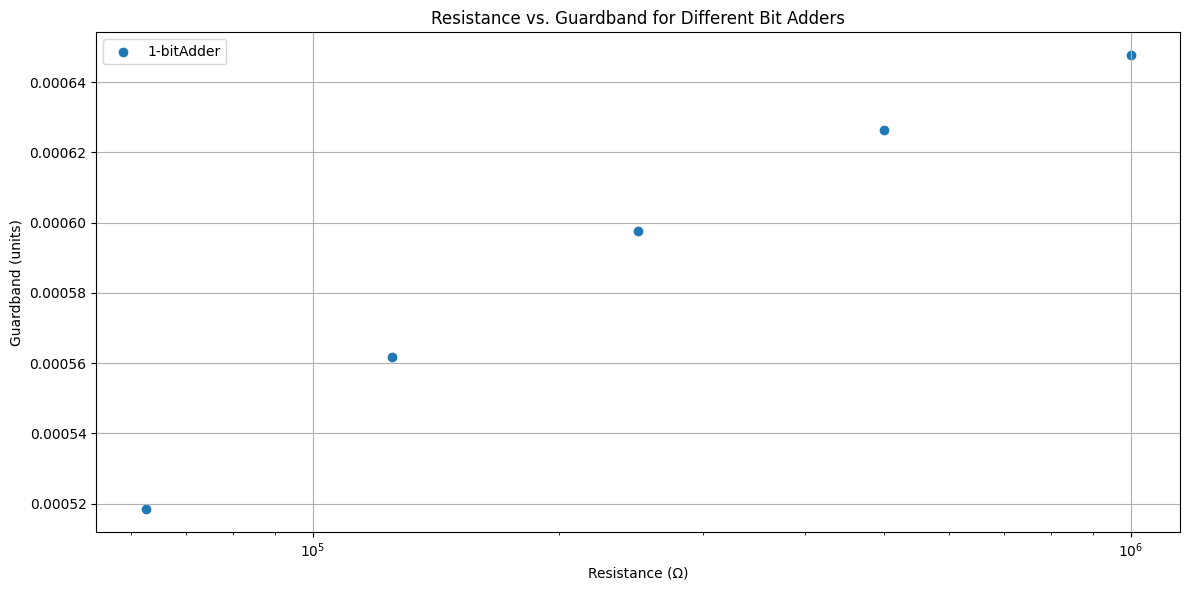

In [421]:
plt.figure(figsize=(12, 6))

# A color map or predefined list of colors can be used if you have multiple adders
# For example: colors = plt.cm.tab10(np.linspace(0, 1, len(Adder_guardbandsVsReistancesMaps)))
# But often letting matplotlib handle defaults is fine.

for i, (adder_name, data) in enumerate(Adder_guardbandsVsReistancesMaps.items()):
    guardbands = data['guardband']
    resistances = data['resistance_values']

    
    # Plot them (resistance on x-axis, guardband on y-axis)
    # marker='o' to see points, linestyle='-' to connect them
    plt.scatter(
        resistances, guardbands, 
        marker='o', 
        label=adder_name
    )

plt.xscale('log')  # Often helpful if resistance spans large orders of magnitude
plt.xlabel('Resistance (Ω)')
plt.ylabel('Guardband (units)')
plt.title('Resistance vs. Guardband for Different Bit Adders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [366]:
Adder_guardbandsVsReistancesMaps

{'1-bitAdder': {'guardband': [0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361,
   0.000631917045347361],
  'resistance_values': [10000000.0,
   5000000.0,
   2500000.0,
   1250000.0,
   625000.0,
   312500.0,
   156250.0,
   78125.0,
   39062.5,
   19531.25]}}

In [47]:
data = {
    'a1': ['0', '0', '1', '1'],
    'a0': ['0', '1', '0', '1'],
    # 'b1': ['1', '1', '1', '1'],
    # 'b0': ['1', '1', '1', '1'],
    'F3': ['0', '0', '0', '1'],
    'F2': ['0', '0', '1', '0'],
    'F1': ['0', '1', '1', '0'],
    'F0': ['0', '1', '0', '1']
}

df = pd.DataFrame(data)
df

a1 a0 F3 F2 F1 F0
0  0  0  0  0  0  0
1  0  1  0  0  1  1
2  1  0  0  1  1  0
3  1  1  1  0  0  1

In [248]:
a="fsdsf"
a.startswith("fsd")

True

In [76]:
def idealCurrentPath(Resistance_matrix, Output_cells):

    R_LRS = 5000
    OutputPaths = {Output_cell:[] for Output_cell in Output_cells}

    # Custom function to emulate an ordered set using a list
    def add_to_ordered_set(ordered_set, element):
        if element not in ordered_set:
            ordered_set.append(element)
    
    # Stack for depth-first traversal
    Stack = []
    
    # Finding paths
    for j in range(len(Resistance_matrix[0])):
        if Resistance_matrix[0][j] == R_LRS:
            Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes
    
    while Stack:
        [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
        for i in range(8):
            if last_curr == 'w':
                if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (i, path_j))
                    Stack.append([(i, path_j), new_visited, 'b'])
            elif last_curr == 'b':
                if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (path_i, i))
                    Stack.append([(path_i, i), new_visited, 'w'])
        if((path_i, path_j) in OutputPaths):
            OutputPaths[(path_i, path_j)] = visited

    return OutputPaths

R_HRS       = 1e9
R_LRS       = 5000

Resitance_matrix = [
      #1       2      3     4      5      6      7      8
    [R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS],
    [R_LRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
    [R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS],
    [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
]

Output_lines_cells = {'F0':(5, (4, 5-1)), 'F1':(6, (2, 6-1)), 'F2':(7, (5, 7-1)), 'F3':(8, (3 ,8-1))}
Output_cells = {Output_cell for _,Output_cell in Output_lines_cells.values()}

idealCurrentPath(Resitance_matrix, Output_cells)

{(4, 4): [(0, 0), (4, 0), (4, 4)],
 (3, 7): [(0, 0), (3, 0), (3, 7)],
 (2, 5): [(0, 0), (3, 0), (3, 1), (2, 1), (2, 5)],
 (5, 6): [(0, 0), (3, 0), (3, 1), (2, 1), (2, 2), (5, 2), (5, 6)]}

In [97]:
def ValidatePathCurrent(literals, col_mappings, high_resitivity = 2e9, isPlot = False):
    # Resistor parameters
    R_Off       = 1e9    # Very large (transistor off)
    R_HRS       = high_resitivity    # High-resistance state of the memory cell
    R_LRS       = 5000    # Low-resistance state (example, or swap values as needed)
    R_Line_Out  = 2e2    # 200 ohms from each column node to GND (example)
    R_Not       = 1e9
    
    # Resitance matrix
    # Resitance_matrix = [
    #       #1       2      3     4      5      6      7      8
    #     [R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
    #     [R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
    #     [R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS],
    #     [R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS],
    #     [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
    #     [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
    #     [R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS],
    #     [R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
    # ]

    Resitance_matrix = [
          #1       2      3     4      5      6      7      8
        [R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS],
        [R_LRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
        [R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS],
        [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
    ]
    
    #Close transistor gate connected to uncharged selector lines
    # Selector_lines = {1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:1, 8:1}
    # literals = {'a0':0, 'a1':0}
    # col_mappings = ['a0', 1, 'a1', 'a1', '~a0', '~a1', 1, 1]
    Selector_lines = {}
    for i, col_mapping in enumerate(col_mappings):
        if(col_mapping==1):
            Selector_lines[i+1] = 1
            continue
        negation = False
        if(col_mapping[0]=="~"):
            negation = True
            label = col_mapping[1:]
        else:
            label = col_mapping

        if(negation and literals[label]==1):
            Selector_lines[i+1] = 0
        elif(negation==False and literals[label]==0):
            Selector_lines[i+1] = 0
        else:
            Selector_lines[i+1] = 1
    
    for j in Selector_lines:
        for i in range(len(Resitance_matrix)):
            if(Selector_lines[j]!=1):
                Resitance_matrix[i][j-1] = R_Off
                
    
    #Output lines
    # Output_lines_cells = {'F1':(2, (2, 2-1)), 'F3':(4, (3 ,4-1)), 'F0':(7, (6, 7-1)), 'F2':(8, (7, 8-1))}
    Output_lines_cells = {'F0':(5, (4, 5-1)), 'F1':(6, (2, 6-1)), 'F2':(7, (5, 7-1)), 'F3':(8, (3 ,8-1))}
    
    Output_cells = {Output_cell for _,Output_cell in Output_lines_cells.values()}
    Output_cells_map = {Output_lines_cells[key][1]:key for key in Output_lines_cells}
    
    Output_lines = {Output_line for Output_line,_ in Output_lines_cells.values()}
    Output_lines_map = {Output_lines_cells[key][0]:key for key in Output_lines_cells}
    
    OutputPaths = idealCurrentPath(Resitance_matrix, Output_cells)
    # print(OutputPaths)
    
    AllOutputPaths =  [item for sublist in OutputPaths.values() for item in sublist]
    AllLRS =  [(row_i, row_j) for row_i, row in enumerate(Resitance_matrix) for row_j, val in enumerate(row) if val==R_LRS]
    
    # 1. row voltages and column voltages as symbolic variables
    Vr = sympy.symbols('Vr1 Vr2 Vr3 Vr4 Vr5 Vr6 Vr7 Vr8', real=True)
    Vc = sympy.symbols('Vc1 Vc2 Vc3 Vc4 Vc5 Vc6 Vc7 Vc8', real=True)
    
    # Voltages together in a single list for convenience
    x_vars = list(Vr) + list(Vc)
    
    #Voltage source
    Vsrc = 0.2
    
    # 2. Build the 16 KCL equations (8 row and 8 column equations to find their voltage)
    equations = []
    
    for i in range(8):
        if(i==0):   #First wordline connected to voltage source
            eq_i = sympy.Eq(Vr[i], Vsrc)
        else:
            row_crossbar_sum = 0
            for j in range(8):
                row_crossbar_sum += 1/Resitance_matrix[i][j] * (Vr[i] - Vc[j])
            eq_i = sympy.Eq(row_crossbar_sum, 0)
        equations.append(eq_i)
    
    for j in range(8):
        if(j+1 in Output_lines):
            col_to_ground = Vc[j] / R_Line_Out
        else:
            col_to_ground = Vc[j] / R_Not
            
        col_crossbar_sum = 0
        for i in range(8):
            col_crossbar_sum += 1/Resitance_matrix[i][j] * (Vc[j] - Vr[i])
        eq_j = sympy.Eq(col_to_ground + col_crossbar_sum, 0)
        equations.append(eq_j)
    
    # ----------------------------------------------------------------
    # 3) Solve the system A*x = b
    A, b = sympy.linear_eq_to_matrix(equations, x_vars)
    solution = A.LUsolve(b)
    
    Voltages = {}
    
    for var, val in zip(x_vars, solution):
        Voltages[f"{var}"] = val.evalf()*1000
        
    currentInDevices = [[0 for _ in range(8)] for _ in range(8)]
    for i in range(8):
        for j in range(8):
            currentInDevices[i][j] = (Voltages['Vr'+str(i+1)]-Voltages['Vc'+str(j+1)])/Resitance_matrix[i][j]
    
    Outputs_map = {}
    
    for key in OutputPaths:
        output_label = Output_cells_map[key]
        Outputs_map[output_label] = OutputPaths[key]
    
    Output_current_map = {}
    for Output_line in Output_lines:
        output_label = Output_lines_map[Output_line]
        Output_current_map[output_label] = Voltages['Vc'+str(Output_line)] / R_Line_Out

    if(isPlot):
        # Converting all numbers in currentInDevices to their absolute values
        currentInDevices_abs = [[abs(value) for value in row] for row in currentInDevices]
        
        # Convert to a numeric numpy array
        data = np.array(currentInDevices_abs, dtype=float)
        
        # Re-plotting the heatmap with absolute values and displaying text on each cell
        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap='coolwarm', interpolation='nearest')
        plt.colorbar(label='Current Value')
        
        # Add text annotations on each cell
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                # if((i,j) in AllOutputPaths):
                if((i,j) in AllLRS):
                    plt.text(j, i, "1", ha='center', va='center', color='black', fontsize=12, fontweight='bold')
                plt.text(j, i+0.25, f"{data[i, j]:.2e}", ha='center', va='center', color='black')
        
        # Add labels and title
        plt.title("Heatmap of Current Values (Absolute with Text)")
        plt.xlabel("Devices")
        plt.ylabel("Measurements")
        plt.xticks(ticks=np.arange(data.shape[1]), labels=[f"Device {i+1}" for i in range(data.shape[1])])
        plt.yticks(ticks=np.arange(data.shape[0]), labels=[f"Row {i+1}" for i in range(data.shape[0])])
        
        # Show the plot
        plt.tight_layout()
        plt.show()
    
    return Output_current_map

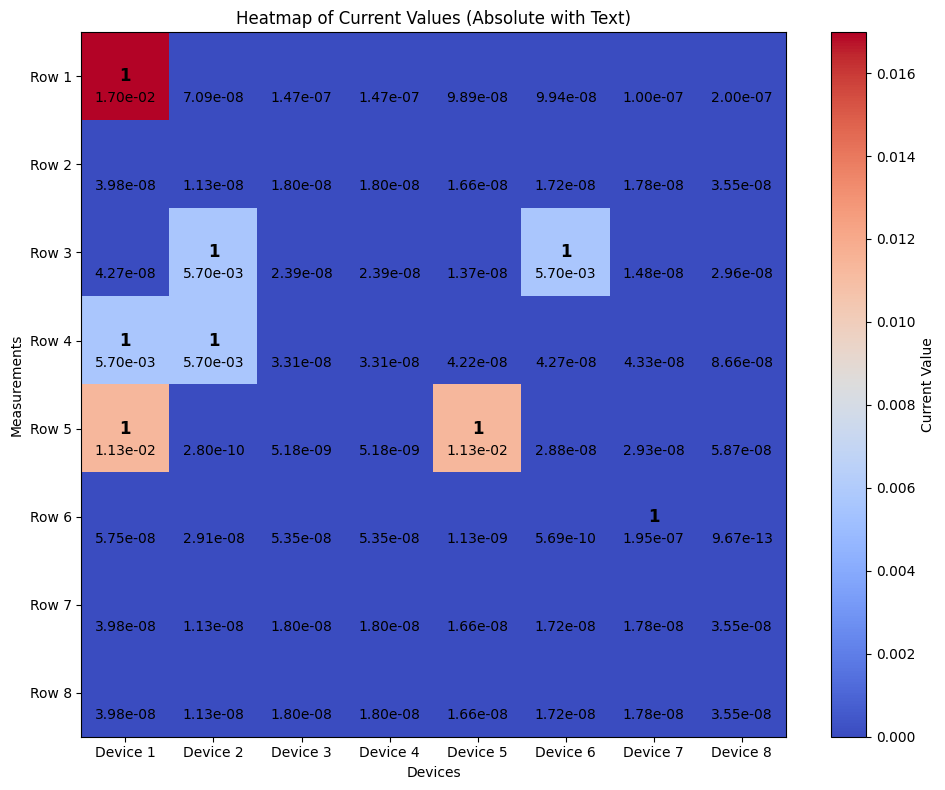

{'F3': 4.81422325716084e-7, 'F0': 0.0112836170659531, 'F1': 0.00569774831032570, 'F2': 4.35989610295791e-7}


a1 a0 F3 F2 F1 F0
0  0  0  0  0  0  0
1  0  1  0  0  1  1
2  1  0  0  1  1  0
3  1  1  1  0  0  1

In [98]:
# col_mappings = ['a0', 1, 'a1', 'a1', '~a0', '~a1', 1, 1] #fixed
col_mappings = ['a0', '~a1', 'a1', '~a0', 1, 1, 1, 'a1'] #fixed


literals = {'a1':0, 'a0':1}
Output_current_map = ValidatePathCurrent(literals, col_mappings, high_resitivity = 2e9, isPlot = True)
print(Output_current_map)
df

In [99]:
guard_values = []
resistance_values = []
lower_bound=0
upper_bound=2e9
thresholds = []

for i in range(30):
    resitance_value = (lower_bound + upper_bound) / 2
    
    #Iterate over the DataFrame and validate each row
    zeroLiteralCurrents, oneLiteralCurrents = [], []
    for index, row in df.iterrows():
        literals = {'a0': int(row['a0']), 'a1': int(row['a1'])}
        results = ValidatePathCurrent(literals, col_mappings, high_resitivity = resitance_value)
        for result_current_label in results:
            if(row[result_current_label]=='0'):
                zeroLiteralCurrents.append(results[result_current_label])
            if(row[result_current_label]=='1'):
                oneLiteralCurrents.append(results[result_current_label])
                
    guardValue = min(oneLiteralCurrents) - max(zeroLiteralCurrents)

    # Binary search adjustment based on guard value
    flag=False
    if guardValue > 0:
        upper_bound = resitance_value
        flag=True
    else:
        lower_bound = resitance_value

    if(flag):
        guard_values.append(guardValue)
        resistance_values.append(resitance_value)
        thresholds.append(max(zeroLiteralCurrents)+guardValue/2)

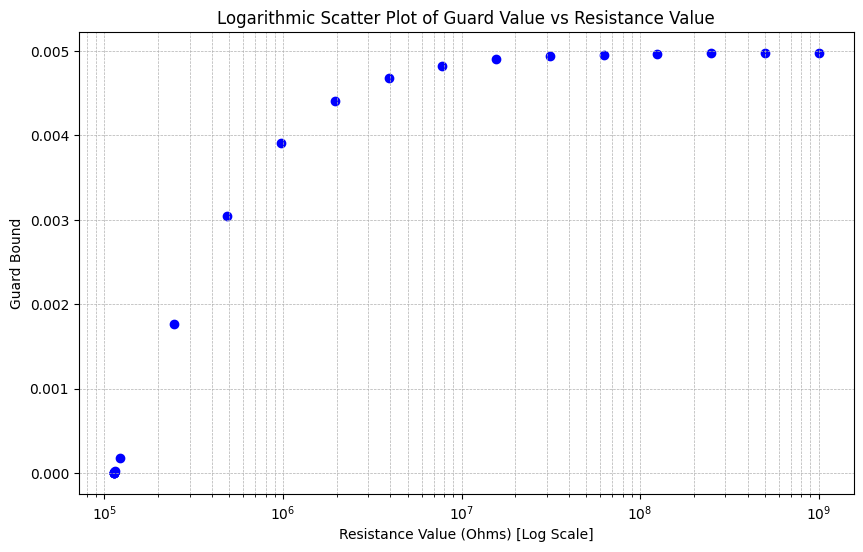

Resistance Value (Ohms)           Guard Bound       Threshold (mA)
20             1.130477e+05   2.87200087843720e-9  0.00702998730788448
19             1.130551e+05   1.56230849359014e-7  0.00702975896502498
18             1.130700e+05   4.62921557584269e-7  0.00702930235618518
17             1.131296e+05   1.68932464466188e-6  0.00702747694520366
16             1.132488e+05   4.14040521478070e-6  0.00702383103256851
15             1.134872e+05   9.03567406018886e-6  0.00701655877864123
14             1.144409e+05   2.85252748267947e-5  0.00698772798122605
13             1.220703e+05  0.000179333156612785  0.00677096978111059
12             2.441406e+05   0.00176370217464953  0.00496457026341179
11             4.882812e+05   0.00304702248888890  0.00386206212100797
10             9.765625e+05   0.00390420965915073  0.00322066754091437
9              1.953125e+06   0.00440826462377047  0.00286772163165907
8              3.906250e+06   0.00468306061987668  0.00268139741503076
7              7.812500e+06   0.00482674980309519  0.00258549536585298
6              1.562500e+07   0.00490025067143208  0.00253682055738357
5              3.125000e+07   0.00493742617902196  0.00251229707667779
4              6.250000e+07   0.00495612155012370  0.00249998817894150
3              1.250000e+08   0.00496549618528367  0.00249382190170676
2              2.500000e+08   0.00497019002010702  0.00249073587494264
1              5.000000e+08   0.00497253817082984  0.00248919226397533
0              1.000000e+09   0.00497371199498755  0.00248842047314849

In [100]:
# Plotting the scatter plot with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.scatter(resistance_values, guard_values, color='blue', marker='o')

# Adding labels and title with logarithmic scale for the x-axis
plt.xscale('log')
plt.xlabel('Resistance Value (Ohms) [Log Scale]')
plt.ylabel('Guard Bound')
plt.title('Logarithmic Scatter Plot of Guard Value vs Resistance Value')

# Display the plot
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


result_data = {
    'Resistance Value (Ohms)': resistance_values,
    'Guard Bound': guard_values,
    'Threshold (mA)': thresholds
}
resistance_df = pd.DataFrame(result_data)

# Sorting the dataframe by resistance values in ascending order
resistance_df_sorted = resistance_df.sort_values(by='Resistance Value (Ohms)')

resistance_df_sorted

In [27]:
print(path.Expressions['F0'])

@10


In [82]:
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import deque

class SBDDParser:
    """ Parses an SBDD (Binary Decision Diagram) file and builds a NetworkX graph. """
    def __init__(self, filename):
        self.filename = filename
        self.model_name = ""
        self.TreeMapInNodes = {}
        self.NodeIDMap = {}
        self.Expressions = {}  # Mapping of output variable to root node
        
        self.Graph = nx.DiGraph()  # Directed graph for visualization
        
        self.node_colors = {}  # Dictionary to store node colors

    def parse_file(self):
        """ Reads the file and extracts nodes, variables, and outputs. """
        with open(self.filename, 'r') as file:
            lines = [line.strip() for line in file if line.strip()]

        unprocessed_lines = []
        for line in lines:
            if line.startswith('.model'):
                self.model_name = line.split()[1:]
            elif line.startswith('.bdd') or line.startswith('.order') or line.startswith('.inputs') or line.startswith('.outputs'):
                continue  # Ignore section marker
            elif line.startswith('.end'):
                break  # Stop parsing at .end
            else:
                unprocessed_lines.append(line)
        self._parse_bdd_lines(unprocessed_lines)

    def _parse_bdd_lines(self, lines):
        """ Parses a BDD node definition line and assigns node colors. """
        outputLiteral = {}
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) == 5:
                node_id, high_child_id, low_child_id, var, output = parts  # Root node
            elif len(parts) == 4:
                node_id, high_child_id, low_child_id, var = parts
                output = None  # Some nodes may not specify an explicit output
            else:
                return  # Skip malformed lines
    
            # Convert to integers where applicable
            node_id = int(node_id, 16) if re.match(r'^[0-9a-fA-F]+$', node_id) else int(node_id)
            low_child_id = int(low_child_id, 16) if low_child_id != "-1" else -1
            high_child_id = int(high_child_id, 16) if high_child_id != "-1" else -1
            
            if(var=='0'):
                outputLiteral[node_id] = var
            elif(var=='1'):
                outputLiteral[node_id] = var
            else:
                # Store node structure in TreeMapInNodes
                self.TreeMapInNodes[node_id] = {
                    "variable": var,
                    "low": low_child_id,
                    "high": high_child_id,
                    "negation": False,  # Assuming no negation flag in file
                }
    
            # Store reference count in NodeIDMap
            if node_id not in self.NodeIDMap:
                self.NodeIDMap[node_id] = [0, var]
            self.NodeIDMap[node_id][0] += 1
    
            # Track root nodes per output variable
            if output:
                self.Expressions[output] = node_id

# 📌 Usage Example
filename = "bdds/test3.sbdd"  # Change this to your actual BDD file
parser = SBDDParser(filename)
parser.parse_file()

In [83]:
# {'ID': id_str, 'literal': literal, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}
parser.NodeIDMap

{28: [1, 'a'], 30: [1, 'a'], 27: [1, 'b'], 17: [1, '1'], 18: [1, '0']}

In [84]:
parser.TreeMapInNodes
# parser.Expressions

{28: {'variable': 'a', 'low': 17, 'high': 27, 'negation': False},
 30: {'variable': 'a', 'low': 18, 'high': 27, 'negation': False},
 27: {'variable': 'b', 'low': 17, 'high': 18, 'negation': False}}

In [85]:
# {'ID': id_str, 'literal': literal, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}
path.NodeIDMap

{'@10': [1, 'a'],
 '@9': [1, 'b'],
 '@-1': [7, '0'],
 '@7': [1, 'b'],
 '@1': [7, '1'],
 '@5': [4, 'cin'],
 '@23': [1, 'a'],
 '@-14': [1, 'b'],
 '@14': [1, 'b'],
 '@-5': [2, 'cin']}

In [86]:
path.TreeMapInNodes

{'@10': {'variable': 'a', 'negation': False, 'low': '@9', 'high': '@7'},
 '@9': {'variable': 'b', 'negation': False, 'low': '@-1', 'high': '@5'},
 '@7': {'variable': 'b', 'negation': False, 'low': '@5', 'high': '@1'},
 '@5': {'variable': 'cin', 'negation': False, 'low': '@-1', 'high': '@1'},
 '@23': {'variable': 'a', 'negation': False, 'low': '@-14', 'high': '@14'},
 '@-14': {'variable': 'b', 'negation': True, 'low': '@-5', 'high': '@5'},
 '@14': {'variable': 'b', 'negation': False, 'low': '@-5', 'high': '@5'},
 '@-5': {'variable': 'cin', 'negation': True, 'low': '@-1', 'high': '@1'}}